# Fall 2024 Launch Data

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math

plt.rcParams.update({
    "figure.facecolor": (1,1,1,1),
    "axes.facecolor": (1,1,1,1),
    "savefig.facecolor": (1,1,1,1)
})

## File paths 

In [2]:
folder_path = os.path.join("..","Fall2024Data")
flash_data_raw = os.path.join(folder_path, "ASCEND_DATA_2024_11_25_19_13_57.csv")
data2 = os.path.join(folder_path, "DATA2.CSV")
data3 = os.path.join(folder_path, "DATA3.CSV")
data4 = os.path.join(folder_path, "DATA4.CSV")
geiger_data = os.path.join(folder_path, "RadiaCode Log.txt")
geiger_spectrum_xml = os.path.join(folder_path, "RadiaCode_ Spectrum.xml")

aprs_data_csv = os.path.join(folder_path, "aprsfi_KA7NSR-9_data.csv")

# create directory for processed files:
temp_folder = "F24Processed"
os.makedirs(temp_folder, exist_ok=True)

# folder to store graphs
graph_folder = "Graphs"
os.makedirs(graph_folder, exist_ok=True)

## Header tool 

In [3]:
def parseHeader(header_field):
    header_field = int(header_field, 16)
    full_no_fail_header = [
      "Header,",
      "Millis,",

      "PCFTime, ", 
      # "DS3231Time,DS3231TempC,",
      "BMETemp(C),BMEPress(hPa),BMEHum(%),BMEGas(KOhms),BMEAlt(m),",    
      # "GeigerSensor(CPS),", 
      "INACurr(mA),INAVolt(mV),INAPow(mW),",                   
      "LSM9DS1 AccX, LSM9DS1 AccY, LSM9DS1 AccZ, LSM9DS1 GyroX, LSM9DS1 GyroY, LSM9DS1 GyroZ, LSM9DS1 MagX, LSM9DS1 MagY, LSM9DS1 MagZ,", 
      # "SHTHum(%), SHTTemp(C),",
      "PicoTemp(C),",
      #"WindADC,TempADC,", 
      "SGPTVOC(ppb),SGPeCO2(ppm),SGPTVOCBase(ppb),SGPeCO2Base(ppb),SGPH2,SGPEtha,",
      "BME280RelHum %,BME280Pres Pa,BME280Alt m,BME280TempC,DewPointC,",  
      "ENSAQI,ENSTVOC ppb,ENSECO2 ppm,",
      "UVA2(nm),UVB2(nm),UVC2(nm),",
      "UVA0(nm),UVB0(nm),UVC0(nm),",
      "ICM AccX,ICM AccY,ICM AccZ,ICM GyroX,ICM GyroY,ICM GyroZ,ICM MagX,ICM MagY,ICM MagZ,ICM TempC,",
      "MTK_Date,MTK_Lat,MTKLong,MTKSpeed,MTKAngle,MTKAlt,MTKSats,",
      " "  # final space for matching fsw?
    ]
    header_bin = bin(header_field)[2:]
    header_bin = header_bin[header_bin.find("1"):] # trim to first 1
    header = "Receive time, "
    for i in range(len(header_bin)): # add each from full header if 1
        if header_bin[i] == "1": header += full_no_fail_header[i]
    return header

# Geiger Sensor 

In [4]:
geiger_csv_path = os.path.join(temp_folder, "geiger.csv")
with open(geiger_csv_path, "w") as fout, open(geiger_data, "r") as fin:
    for line in fin:
        line = line.replace(";", ",")
        fout.write(line)

geiger_df = pd.read_csv(geiger_csv_path, skipinitialspace=True, skiprows=range(1,15))
print(list(geiger_df.columns))


['Time', 'Timestamp', 'Event', 'Count Rate', 'cps', 'Dose rate', 'Sv/h', 'Dose Rate Error', '%', 'Dose Rate Alarm', 'Dose Alarm', 'Duration of dose accumulation', 'sec.', 'Dose', 'Sv', 'Temperature', 'Latitude', 'Longitude', 'Comment']


7.2 99.0


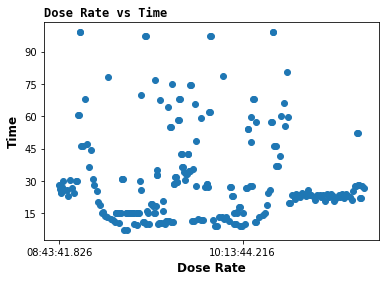

In [5]:
print(geiger_df["Dose rate"].min(), geiger_df["Dose rate"].max())

fig, ax = plt.subplots()
plt.scatter([i.split()[1] for i in geiger_df["Time"]], geiger_df["Dose rate"])
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.title("Dose Rate vs Time", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.ylabel("Time", fontsize="large", fontweight="bold")
plt.xlabel("Dose Rate", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, "geiger_dose_rate_vs_time.svg"))
plt.savefig(os.path.join(graph_folder, "geiger_dose_rate_vs_time.png"))
plt.show()

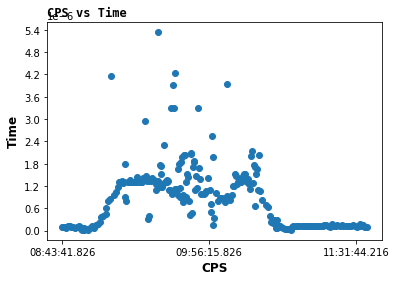

In [6]:
fig, ax = plt.subplots()
plt.scatter([i.split()[1] for i in geiger_df["Time"]], geiger_df["cps"])

plt.title("CPS vs Time", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.ylabel("Time", fontsize="large", fontweight="bold")
plt.xlabel("CPS", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, "geiger_cps_vs_time.svg"))
plt.savefig(os.path.join(graph_folder, "geiger_cps_vs_time.png"))

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
plt.show()

# Payload Sensors

In [7]:
# combine the data
payload_data = os.path.join(temp_folder, "payload_data.csv")
skipped = []
with open(payload_data, "w") as fout:
    with open(data2) as fin:
        for line in fin:
            fout.write(line)
    with open(data3) as fin:
        for line in fin:
            if(line.split(",")[0] == "3f82"):
                fout.write(line)
            else:
                skipped.append(line)
    with open(data4) as fin:
        for line in fin:
            if(line.split(",")[0] == "3f82"):
                fout.write(line)
            else:
                skipped.append(line)
print(len(skipped))
print(skipped)

0
[]


In [8]:
# get flash data
flash_data = os.path.join(temp_folder, "flash_data_header.csv")
with open(flash_data_raw, "r") as fin, open(flash_data, "w") as fout:
    finlist = list(fin)
    fout.write(parseHeader(finlist[0].split(",")[1]) + "\n")
    for line in finlist:
        if(line.split(",")[1] == " 3f82"):
            fout.write(line)

In [9]:
custom_na = pd._libs.parsers.STR_NA_VALUES
custom_na.add("-")
payload_df = pd.read_csv(payload_data, skipinitialspace=True, na_values=custom_na)
print(list(payload_df.columns))
flash_df = pd.read_csv(flash_data, skipinitialspace=True, na_values=custom_na)
print(list(flash_df.columns))

['Header', 'Millis', 'PCFTime', 'BMETemp(C)', 'BMEPress(hPa)', 'BMEHum(%)', 'BMEGas(KOhms)', 'BMEAlt(m)', 'INACurr(mA)', 'INAVolt(mV)', 'INAPow(mW)', 'LSM9DS1 AccX', 'LSM9DS1 AccY', 'LSM9DS1 AccZ', 'LSM9DS1 GyroX', 'LSM9DS1 GyroY', 'LSM9DS1 GyroZ', 'LSM9DS1 MagX', 'LSM9DS1 MagY', 'LSM9DS1 MagZ', 'PicoTemp(C)', 'SGPTVOC(ppb)', 'SGPeCO2(ppm)', 'SGPTVOCBase(ppb)', 'SGPeCO2Base(ppb)', 'SGPH2', 'SGPEtha', 'ICM AccX', 'ICM AccY', 'ICM AccZ', 'ICM GyroX', 'ICM GyroY', 'ICM GyroZ', 'ICM MagX', 'ICM MagY', 'ICM MagZ', 'ICM TempC', 'MTK_Date', 'MTK_Lat', 'MTKLong', 'MTKSpeed', 'MTKAngle', 'MTKAlt', 'MTKSats', 'Unnamed: 44']
['Receive time', 'Header', 'Millis', 'PCFTime', 'BMETemp(C)', 'BMEPress(hPa)', 'BMEHum(%)', 'BMEGas(KOhms)', 'BMEAlt(m)', 'INACurr(mA)', 'INAVolt(mV)', 'INAPow(mW)', 'LSM9DS1 AccX', 'LSM9DS1 AccY', 'LSM9DS1 AccZ', 'LSM9DS1 GyroX', 'LSM9DS1 GyroY', 'LSM9DS1 GyroZ', 'LSM9DS1 MagX', 'LSM9DS1 MagY', 'LSM9DS1 MagZ', 'PicoTemp(C)', 'ICM AccX', 'ICM AccY', 'ICM AccZ', 'ICM GyroX', '

## Comparison (SD vs Flash)

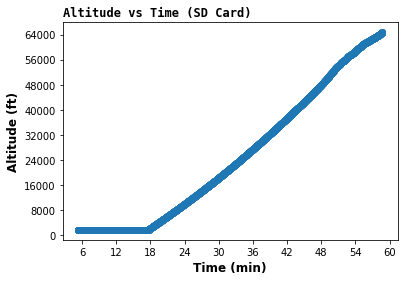

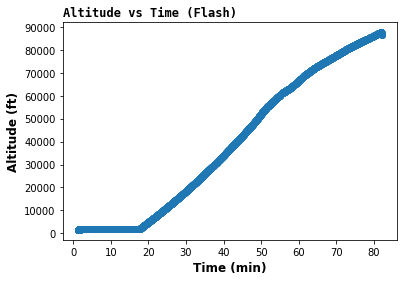

SD Max:  64734.385273600004
Flash Max:  87694.7862708


In [10]:
fig, ax = plt.subplots()
plt.scatter([(i / 1000 / 60) for i in payload_df["Millis"]], [i * 3.28084 for i in payload_df["BMEAlt(m)"]])
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.title("Altitude vs Time (SD Card)", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.xlabel("Time (min)", fontsize="large", fontweight="bold")
plt.ylabel("Altitude (ft)", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, "sd_alt_vs_time.svg"))
plt.savefig(os.path.join(graph_folder, "sd_alt_vs_time.png"))

plt.show()

fig, ax = plt.subplots()
plt.scatter([(i / 1000 / 60) for i in flash_df["Millis"]], [i * 3.28084 for i in flash_df["BMEAlt(m)"]])
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.title("Altitude vs Time (Flash)", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.xlabel("Time (min)", fontsize="large", fontweight="bold")
plt.ylabel("Altitude (ft)", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, "flash_alt_vs_time.svg"))
plt.savefig(os.path.join(graph_folder, "flash_alt_vs_time.png"))

plt.show()

print("SD Max: " , payload_df["BMEAlt(m)"].max() * 3.28084)
print("Flash Max: " , flash_df["BMEAlt(m)"].max() * 3.28084)

## General plots (using Flash)

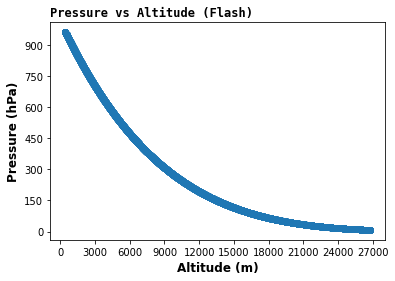

In [11]:
fig, ax = plt.subplots()
plt.scatter(flash_df["BMEAlt(m)"], flash_df["BMEPress(hPa)"])
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.title("Pressure vs Altitude (Flash)", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.xlabel("Altitude (m)", fontsize="large", fontweight="bold")
plt.ylabel("Pressure (hPa)", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, "pressure_vs_altitude.svg"))
plt.savefig(os.path.join(graph_folder, "pressure_vs_altitude.png"))

plt.show()

### Plots vs Pressure

In [12]:
#tool 
def plotVsPressure(column_name, display_name="", display_units=""):
    if(display_name == ""): display_name = column_name
    fig, ax = plt.subplots()
    plt.scatter(flash_df["BMEPress(hPa)"], flash_df[column_name])
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))
    ax.invert_xaxis()

    plt.title(f"{display_name} vs Pressure (Flash)", fontsize="large", loc="left", fontweight="bold", family="monospace")
    plt.ylabel(f"{display_name} ({display_units})", fontsize="large", fontweight="bold")
    plt.xlabel("Pressure (hPa)", fontsize="large", fontweight="bold")
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(display_name.split())}_vs_pressure.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(display_name.split())}_vs_pressure.png"))
    
    plt.show()

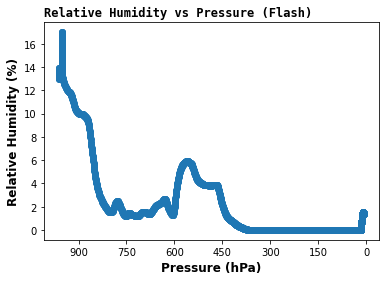

In [13]:
plotVsPressure("BMEHum(%)", "Relative Humidity", "%")

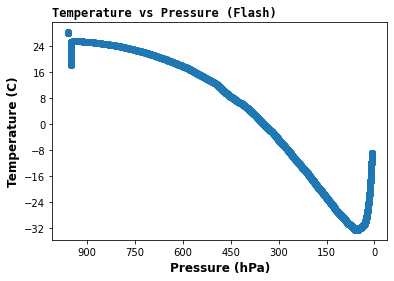

In [14]:
plotVsPressure("BMETemp(C)", "Temperature", "C")

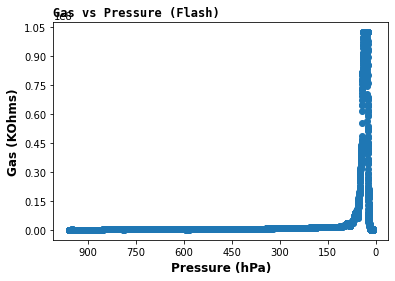

In [15]:
plotVsPressure("BMEGas(KOhms)", "Gas", "KOhms")

### Plots vs Altitude

In [16]:
#tool 
def plotVsAltitude(column_name, display_name="", display_units=""):
    if(display_name == ""): display_name = column_name
    fig, ax = plt.subplots()
    plt.scatter(flash_df["BMEAlt(m)"], flash_df[column_name])
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    plt.title(f"{display_name} vs Altitude (Flash)", fontsize="large", loc="left", fontweight="bold", family="monospace")
    plt.ylabel(f"{display_name} ({display_units})", fontsize="large", fontweight="bold")
    plt.xlabel("Altitude (m)", fontsize="large", fontweight="bold")
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(display_name.split())}_vs_alt.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(display_name.split())}_vs_alt.png"))
    
    plt.show()

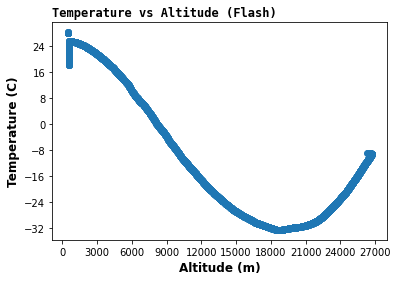

In [17]:
plotVsAltitude("BMETemp(C)", "Temperature", "C")

### Plots vs Time

In [18]:
#tool 
def plotVsTime(column_name, display_name="", display_units="", start_time=-1, stop_time=-1):
    if(display_name == ""): display_name = column_name
    fig, ax = plt.subplots()    
    raw_time = [(i / 1000 / 60) for i in flash_df["Millis"]]
    raw_generic = flash_df[column_name]
    cooked_time = []
    cooked_generic = []
    
    if(start_time != -1 or stop_time != -1):
        # convert to millis
        if(start_time != -1): start_time = start_time
        if(stop_time != -1): stop_time = stop_time
        for i in range(len(raw_time)):
            if((start_time != -1 and raw_time[i] < start_time)): continue
            if((stop_time != -1 and raw_time[i] > stop_time)): break
            cooked_time.append(raw_time[i])
            cooked_generic.append(raw_generic[i])
    else:
        cooked_time = raw_time
        cooked_generic = raw_generic
            
    plt.scatter(cooked_time, cooked_generic)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    plt.title(f"{display_name} vs Time (Flash)", fontsize="large", loc="left", fontweight="bold", family="monospace")
    plt.ylabel(f"{display_name} ({display_units})", fontsize="large", fontweight="bold")
    plt.xlabel("Time (min)", fontsize="large", fontweight="bold")
    
    period = ""
    if start_time != -1:
        period += str(start_time)
    else:
        period += "begin"
    period += "_to_"
    if stop_time != -1:
        period += str(stop_time)
    else:
        period += "end"
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(display_name.split())}_vs_time_{period}.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(display_name.split())}_vs_time_{period}.png"))
    
    plt.show()

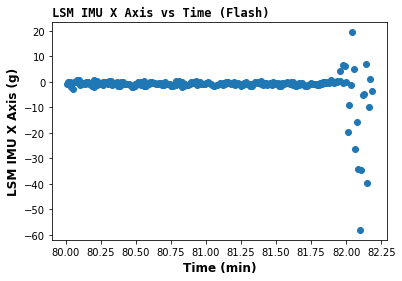

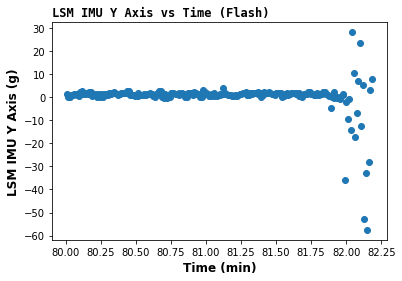

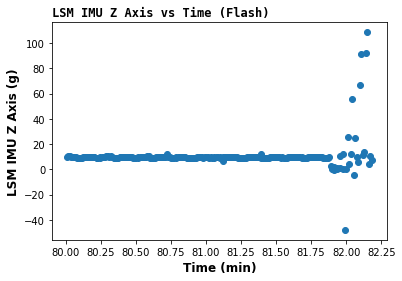

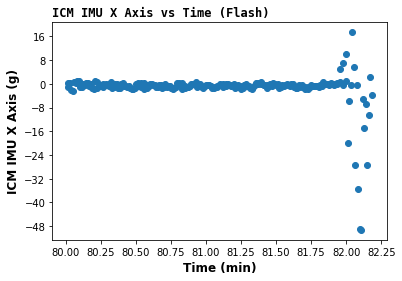

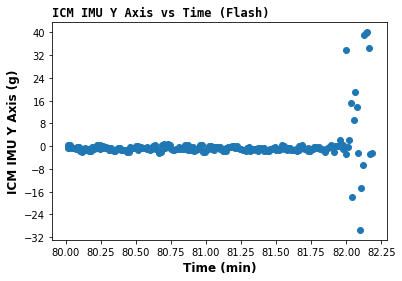

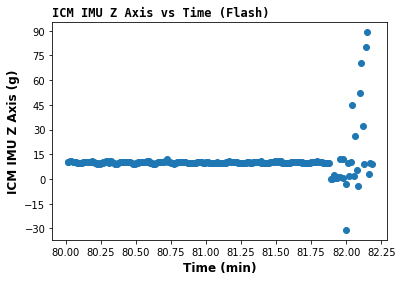

In [19]:
plotVsTime("LSM9DS1 AccX", "LSM IMU X Axis", "g", 80)
plotVsTime("LSM9DS1 AccY", "LSM IMU Y Axis", "g", 80)
plotVsTime("LSM9DS1 AccZ", "LSM IMU Z Axis", "g", 80)

plotVsTime("ICM AccX", "ICM IMU X Axis", "g", 80)
plotVsTime("ICM AccY", "ICM IMU Y Axis", "g", 80)
plotVsTime("ICM AccZ", "ICM IMU Z Axis", "g", 80)

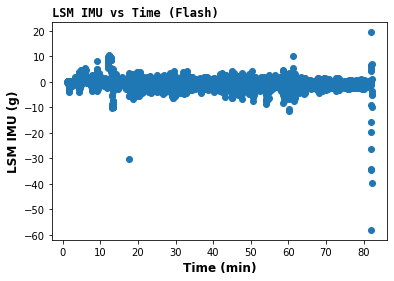

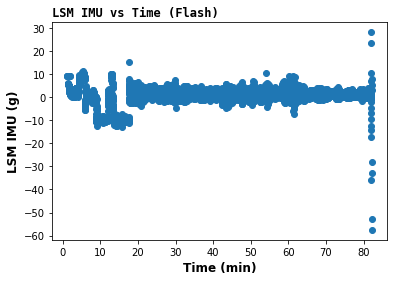

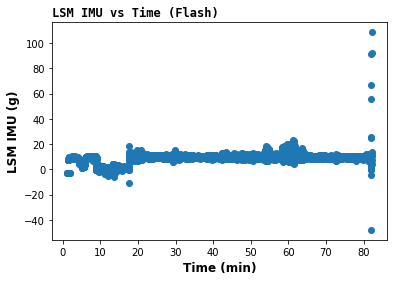

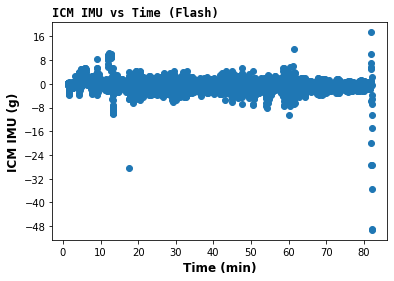

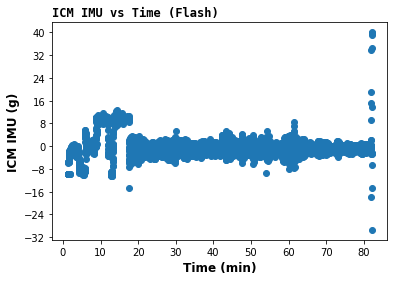

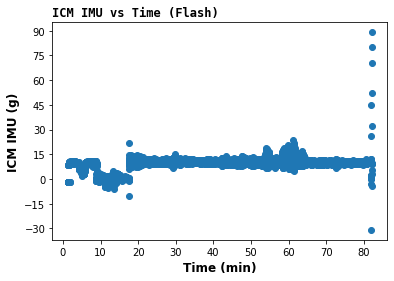

In [20]:
plotVsTime("LSM9DS1 AccX", "LSM IMU", "g")
plotVsTime("LSM9DS1 AccY", "LSM IMU", "g")
plotVsTime("LSM9DS1 AccZ", "LSM IMU", "g")

plotVsTime("ICM AccX", "ICM IMU", "g")
plotVsTime("ICM AccY", "ICM IMU", "g")
plotVsTime("ICM AccZ", "ICM IMU", "g")

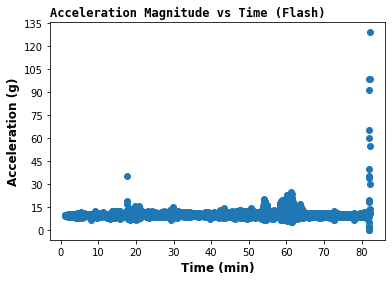

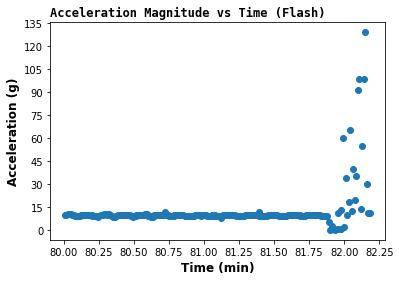

In [21]:
lsm_accel_mag = [math.sqrt(x**2 + y**2 + z**2) for x,y,z in zip(flash_df["LSM9DS1 AccX"], flash_df["LSM9DS1 AccY"], flash_df["LSM9DS1 AccZ"])]

fig, ax = plt.subplots()    
raw_time = [(i / 1000 / 60) for i in flash_df["Millis"]]

plt.scatter(raw_time, lsm_accel_mag)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.title(f"Acceleration Magnitude vs Time (Flash)", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.ylabel(f"Acceleration (g)", fontsize="large", fontweight="bold")
plt.xlabel("Time (min)", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, f"accel_mag_vs_time.svg"))
plt.savefig(os.path.join(graph_folder, f"accel_mag_vs_time.png"))

plt.show()

fig, ax = plt.subplots()    
raw_time = [(i / 1000 / 60) for i in flash_df["Millis"]]

cooked_time = []
cooked_lsm_accel_mag = []
for i in range(len(raw_time)):
    if raw_time[i] > 80:
        cooked_time.append(raw_time[i])
        cooked_lsm_accel_mag.append(lsm_accel_mag[i])

plt.scatter(cooked_time, cooked_lsm_accel_mag)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.title(f"Acceleration Magnitude vs Time (Flash)", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.ylabel(f"Acceleration (g)", fontsize="large", fontweight="bold")
plt.xlabel("Time (min)", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, f"lsm_accel_mag_vs_time_80_to_end.svg"))
plt.savefig(os.path.join(graph_folder, f"lsm_accel_mag_vs_time_80_to_end.png"))

plt.show()

# APRS Data

In [22]:
aprs_df = pd.read_csv(aprs_data_csv)
print(list(aprs_df.columns))

def to_mst(utc):
    parts = utc.split(":")
    parts[0] = str(int(parts[0]) - 7)
    return ":".join(parts)

['time', 'lasttime', 'lat', 'lng', 'speed', 'course', 'altitude', 'comment']


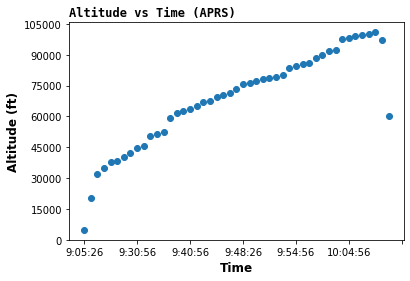

In [23]:
fig, ax = plt.subplots()  

plt.scatter([to_mst(i.split()[1]) for i in aprs_df["time"]], [i * 3.28084 for i in aprs_df["altitude"]])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.title(f"Altitude vs Time (APRS)", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.ylabel(f"Altitude (ft)", fontsize="large", fontweight="bold")
plt.xlabel("Time", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, f"aprs_altitude_vs_time.svg"))
plt.savefig(os.path.join(graph_folder, f"aprs_altitude_vs_time.png"))

plt.show()

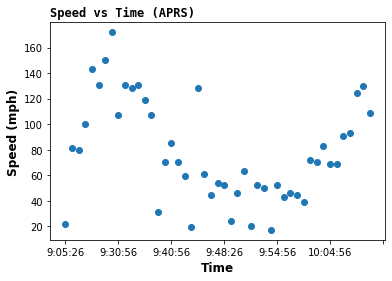

In [24]:
fig, ax = plt.subplots()  

plt.scatter([to_mst(i.split()[1]) for i in aprs_df["time"]], aprs_df["speed"])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.title(f"Speed vs Time (APRS)", fontsize="large", loc="left", fontweight="bold", family="monospace")
plt.ylabel(f"Speed (mph)", fontsize="large", fontweight="bold")
plt.xlabel("Time", fontsize="large", fontweight="bold")

plt.savefig(os.path.join(graph_folder, f"aprs_speed_vs_time.svg"))
plt.savefig(os.path.join(graph_folder, f"aprs_speed_vs_time.png"))

plt.show()